## AIMI High School Internship 2023
### Notebook 2: Training a Vision Model to Predict ET Distances

**The Problem**: Given a chest X-ray, our goal in this project is to predict the distance from an endotracheal tube to the carina. This is an important clinical task - endotracheal tubes that are positioned too far (>5cm) above the carina will not work effectively.

**Your Second Task**: You should now have a training dataset consisting of (a) chest X-rays and (b) annotations indicating the distance of the endotracheal tube from the carina. Now, your goal is to train a computer vision model to predict endotracheal tube distance from the image. You have **two options** for this task, and you may attempt one or both of these:
- *Distance Categorization* : Train a model to determine whether the position of a tube is abnormal (>5.0 cm) or normal (≤ 5.0 cm).
- *Distance Prediction*: Train a model that predicts the distance of the endotracheal tube from the carina in centimeters.

In this notebook, we provide some simple starter code to get you started on training a computer vision model. You are not required to use this template - feel free to modify as you see fit.

**Submitting Your Model**: We have created a leaderboard where you can submit your model and view results on the held-out test set. We provide instructions below for submitting your model to the leaderboard. **Please follow these directions carefully**.

We will evaluate your results on the held-out test set with the following evaluation metrics:
- *Distance Categorization* : We will measure AUROC, which is a metric commonly used in healthcare tasks. See this blog for a good explanation of AUROC: https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/
- *Distance Prediction*: We will measure the mean average error (also known as L1 distance) between the predicted distances and the true distances.


In [3]:
!unzip -qq /content/mimic-train.zip

In [29]:
!mkdir /content/model_weights

mkdir: cannot create directory ‘/content/model_weights’: File exists


In [2]:
# Some libraries that you may find useful are included here.
# To import a library that isn't provided with Colab, use the following command: !pip install torchmetrics
import torch
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
from torchvision import models

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms

In [7]:
class ChestXRayDataset(Dataset):
    def __init__(self, dataframe):
        super(ChestXRayDataset, self).__init__()
        self.dataframe = dataframe

        # Fill in __init__() here

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(f'/content/'+path).convert('RGB')
        conv_tensor = transforms.ToTensor()
        images = conv_tensor(image)
        if 'distance_mm' in self.dataframe.columns:
          labels = torch.tensor(self.dataframe.iloc[idx]['distance_mm'])
          return path, images, labels
        return path, images

In [8]:
def train_val_split(df, train_prop):
    train_count = int(train_prop * len(df))
    train_set = df.sample(train_count)
    val_set = df.drop(train_set.reset_index()['index'],axis=0)
    return ChestXRayDataset(dataframe=train_set), ChestXRayDataset(dataframe=val_set)

In [10]:
df = pd.read_csv('/content/distances.csv',index_col=0)
train_set, val_set = train_val_split(df, .8)

## Define Training Components
Here, define any necessary components that you need to train your model, such as the model architecture, the loss function, and the optimizer.

In [5]:
import torch.nn as nn

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
loss = nn.L1Loss()
model = models.alexnet(pretrained=True)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4) # AdamW is a commonly-used optimizer. Feel free to modify.
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=64, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
for param in model.features.parameters():
    param.requires_grad = False

In [34]:
in_features = model._modules['classifier'][-1].in_features
out_features = 1
model._modules['classifier'][-1] = nn.Linear(4096, out_features, bias=True)
model.classifier.add_module('7', nn.ReLU(inplace=True))
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [35]:
model = model.to(device)

## Training Code
We provide starter code below that implements a simple training loop in PyTorch. Feel free to modify as you see fit.

In [36]:
train_losses = []
val_losses = []

In [37]:

def train(model, loss_fn, train_loader, opt, max_epoch):
    best_val_loss = np.inf
    for epoch in range(0, max_epoch):
        model.train()
        train_loss = 0
        train_batches = 0
        model.train()
        for step, (path, x,y) in tqdm(enumerate(train_loader)):
            opt.zero_grad()
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_fn(y.unsqueeze(1), pred)
            train_loss += float(loss)
            train_batches += 1
            loss.backward()
            opt.step()
        train_loss /= train_batches
        train_losses.append(train_loss)
        val_loss = 0
        val_batches = 0
        model.eval()
        with torch.no_grad():
            for val_path, val_img, val_label in iter(val_loader):
                pred = model(val_img.to(device))
                batch_loss = float(loss_fn(val_label.to(device).unsqueeze(1), pred))
                val_loss += batch_loss
                val_batches += 1
            val_loss /= val_batches
            val_losses.append(val_loss)
            print('Validation loss epoch %d: %f' % (epoch+1, val_loss))
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_metrics = model.parameters()
                torch.save(model.state_dict(), '/content/model_weights/epoch_'+str(epoch+1)+'.ckpt')
                print('New best loss')


In [38]:
val_path, val_features, val_labels = next(iter(val_loader))

In [39]:
out = model(val_features.to(device))

In [40]:
out.size()

torch.Size([64, 1])

In [41]:
initial_loss = loss(val_labels.unsqueeze(1).to(device),out).item()
val_losses.append(initial_loss)
initial_loss

45.3359375

In [42]:
train(model, loss, train_loader, opt, max_epoch=15)

144it [01:06,  2.18it/s]


Validation loss epoch 1: 14.370518
New best loss


144it [01:07,  2.15it/s]


Validation loss epoch 2: 13.470254
New best loss


144it [01:08,  2.11it/s]


Validation loss epoch 3: 13.698217


144it [01:07,  2.15it/s]


Validation loss epoch 4: 13.210239
New best loss


144it [01:10,  2.03it/s]


Validation loss epoch 5: 13.226060


144it [01:06,  2.17it/s]


Validation loss epoch 6: 13.217124


144it [01:05,  2.19it/s]


Validation loss epoch 7: 13.055852
New best loss


144it [01:06,  2.17it/s]


Validation loss epoch 8: 13.429841


144it [01:05,  2.19it/s]


Validation loss epoch 9: 12.934431
New best loss


144it [01:06,  2.15it/s]


Validation loss epoch 10: 12.947112


144it [01:05,  2.19it/s]


Validation loss epoch 11: 12.811401
New best loss


144it [01:06,  2.16it/s]


Validation loss epoch 12: 12.856993


144it [01:06,  2.17it/s]


Validation loss epoch 13: 12.789648
New best loss


144it [01:07,  2.14it/s]


Validation loss epoch 14: 12.953460


144it [01:06,  2.17it/s]


Validation loss epoch 15: 13.095898


In [43]:
import matplotlib.pyplot as plt

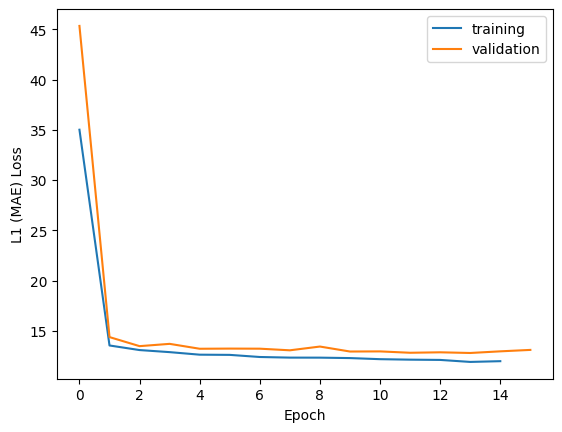

In [44]:
plt.plot(train_losses, label="training")
plt.plot(val_losses, label = "validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('L1 (MAE) Loss')
plt.show()

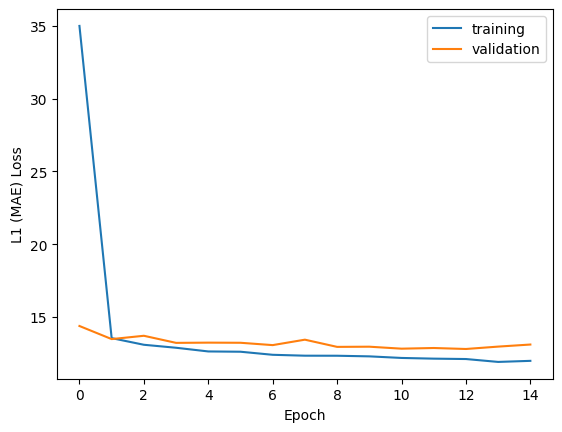

In [47]:
plt.plot(train_losses, label="training")
plt.plot(val_losses[1:], label = "validation")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('L1 (MAE) Loss')
plt.show()

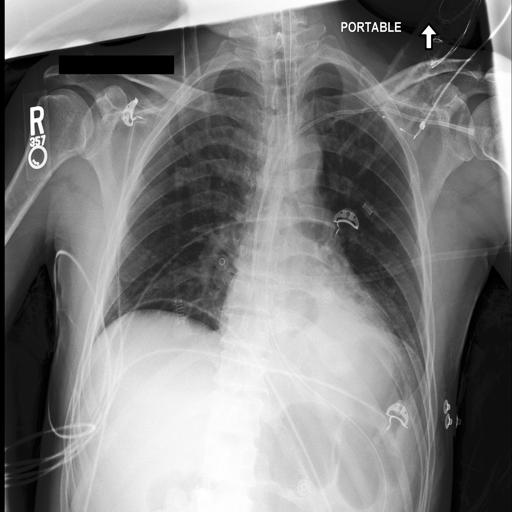

expected:  tensor(41., dtype=torch.float64)
output:  tensor([35.5424], device='cuda:0', grad_fn=<SelectBackward0>)


In [48]:
for val_path, val_img, val_label in val_loader:
  Image.open(f'/content/'+val_path[10]).show()
  print('expected: ', val_label[10])
  print('output: ', model(val_img.to(device))[10])
  break

## Submitting Your Results
Once you have successfully trained your model, generate predictions on the test set and save your results as a `.csv` file. This file can then be uploaded to the leaderboard.

Your final `.csv` file **must** have the following format:
- There must be a column titled `image_path` with the paths to the test set images. This column should be identical to the one provided in `mimic_test_student.csv`.
- There must be a column titled `pred` with your model outputs.
  - If you are running the `distance categorization` task, this column must have floating point numbers ranging between 0 and 1. Higher numbers should indicate a greater likelihood that the tube distance is abnormal. Hint: You can convert model outputs to the 0 to 1 range by applying the sigmoid activation function (torch.nn.sigmoid())
  - If you are running the `distance prediction` task, this column must have numbers representing the tube distance in centimeters.
- Double check that there are 500 rows in your output file

In [52]:
!unzip -qq /content/mimic-test.zip

In [9]:
test_csv = pd.read_csv('/content/mimic_test_student.csv', index_col=0)
test_csv

,split,patient_id,study_id,image_id,image_path
0,test,10345,50410,80276,mimic-test/10345/50410/80276.jpg
1,test,10345,50232,80350,mimic-test/10345/50232/80350.jpg
2,test,10189,50388,80353,mimic-test/10189/50388/80353.jpg
3,test,10127,50441,80124,mimic-test/10127/50441/80124.jpg
4,test,10004,50475,80218,mimic-test/10004/50475/80218.jpg
...,...,...,...,...,...
495,test,10252,50003,80193,mimic-test/10252/50003/80193.jpg
496,test,10363,50408,80072,mimic-test/10363/50408/80072.jpg
497,test,10363,50145,80039,mimic-test/10363/50145/80039.jpg
498,test,10054,50265,80374,mimic-test/10054/50265/80374.jpg


In [14]:
load_model = models.alexnet(pretrained=True)
load_model._modules['classifier'][-1] = nn.Linear(4096, 1, bias=True)
load_model.classifier.add_module('7', nn.ReLU(inplace=True))
load_model.load_state_dict(torch.load('/content/model_weights/epoch_13.ckpt'))
load_model.to(device)
load_model.eval()
test_dataset = ChestXRayDataset(test_csv)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, drop_last=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
preds = []
for path, x in test_loader:
  out = load_model(x.to(device))
  preds.append(out)

In [17]:
all = []
for x in preds:
  for p in x:
    all.append(float(p/10))

In [18]:
len(all)

500

In [19]:
test_results = {"image_path": list(test_csv['image_path']), "tube_distance": all}

In [20]:
test_results = pd.DataFrame(test_results)
test_results.to_csv(f"/content/test.csv")